<a href="https://colab.research.google.com/github/Usman-938/Assignments/blob/main/Word_Embeddings_Amazon_Reviews_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🛒 Word Embeddings: Word2Vec, GloVe & Semantic Analysis
## Amazon Fine Food Reviews Dataset

**Parts Covered:** A (Data Prep) · B (Preprocessing) · C (Word2Vec) · D (GloVe) · E (Cosine Similarity / Search Engine) · F (Clustering)

---
### ⚠️ Before You Start
You need the Amazon Fine Food Reviews dataset from Kaggle.

**Option 1 – Kaggle API (recommended):**
```
1. Go to https://www.kaggle.com/settings → API → Create New Token → download kaggle.json
2. Run the Kaggle Setup cell below
```
**Option 2 – Manual upload:**
```
1. Download Reviews.csv from https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews
2. Upload it to Colab using the file browser (left sidebar) or Files → Upload
3. Skip the Kaggle Setup cell and proceed from Part A
```
---

## 🔧 Install Dependencies

In [9]:
# Install all required packages
!pip install gensim nltk scikit-learn matplotlib seaborn pandas numpy -q
print("✅ Packages installed")

✅ Packages installed


In [10]:
import pandas as pd
import numpy as np
import re
import time
import os
import zipfile
import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from gensim.models import Word2Vec, KeyedVectors
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, confusion_matrix, classification_report
from sklearn.metrics.pairwise import cosine_similarity

# Download NLTK resources
for resource in ['stopwords','punkt','punkt_tab','wordnet','omw-1.4']:
    nltk.download(resource, quiet=True)

print("✅ All imports successful!")

✅ All imports successful!


## 📥 Kaggle Setup (Skip if uploading manually)

In [11]:
# # ── OPTION 1: Kaggle API ──────────────────────────────────────────────
# # Upload your kaggle.json when prompted
# from google.colab import files

# print("Upload your kaggle.json file (from Kaggle → Settings → API → Create New Token)")
# uploaded = files.upload()  # prompts file picker
df_full = pd.read_csv('Reviews.csv')
print("✅ Kaggle.json uploaded")

# # Move kaggle.json to correct location
# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# # # Download the dataset
# # !kaggle datasets download -d snap/amazon-fine-food-reviews
# # !unzip -q amazon-fine-food-reviews.zip
# # print("✅ Dataset downloaded via Kaggle API")

✅ Kaggle.json uploaded


---
## Part A – Data Preparation

In [12]:
# ── Load Dataset ──────────────────────────────────────────────────────
# Try multiple possible filenames
for fname in ['Reviews.csv', 'amazon-fine-food-reviews/Reviews.csv', 'reviews.csv']:
    if os.path.exists(fname):
        raw_df = pd.read_csv(fname)
        print(f"✅ Loaded: {fname}")
        break
else:
    raise FileNotFoundError("❌ Reviews.csv not found. Please upload it manually or run the Kaggle cell above.")

print(f"Raw dataset shape: {raw_df.shape}")
print(f"Columns: {list(raw_df.columns)}")

✅ Loaded: Reviews.csv
Raw dataset shape: (568454, 10)
Columns: ['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text']


📐 Dataset Shape: (5000, 3)

📊 Score Distribution:
Score
1     455
2     248
3     378
4     701
5    3218
Name: count, dtype: int64

🏷️  Sentiment Distribution:
Sentiment
Positive    3919
Negative     703
Neutral      378
Name: count, dtype: int64


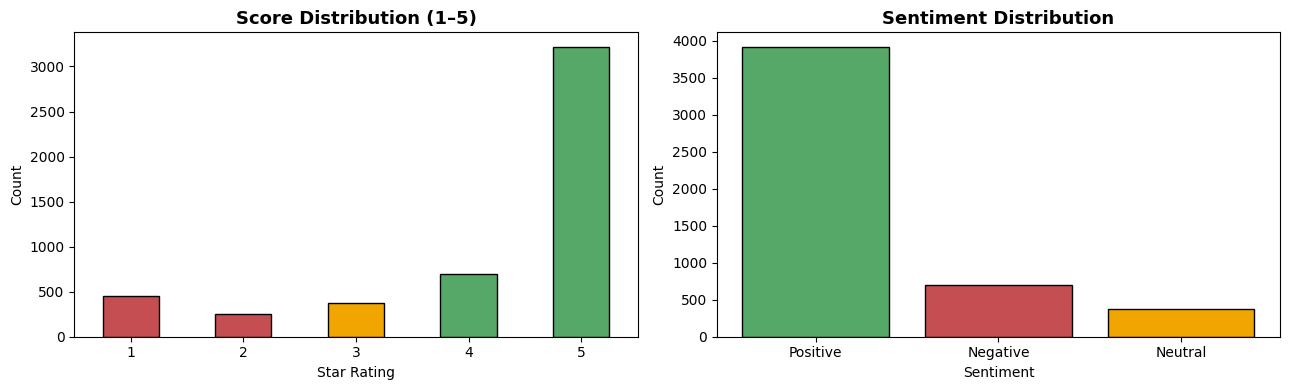


📄 Sample rows:


,Text,Score,Sentiment
0,Having tried a couple of other brands of glute...,5,Positive
1,My cat loves these treats. If ever I can't fin...,5,Positive
2,A little less than I expected. It tends to ha...,3,Neutral


In [13]:
# ── Select 5000 reviews, keep Text + Score ────────────────────────────
df = raw_df[['Text', 'Score']].dropna().copy()

# Sample 5000 with stratified proportions to keep class balance
df = df.sample(n=min(5000, len(df)), random_state=42).reset_index(drop=True)

# ── Create sentiment labels ───────────────────────────────────────────
def score_to_sentiment(score):
    if score >= 4:
        return 'Positive'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Negative'

df['Sentiment'] = df['Score'].apply(score_to_sentiment)

print(f"📐 Dataset Shape: {df.shape}")
print("\n📊 Score Distribution:")
print(df['Score'].value_counts().sort_index())
print("\n🏷️  Sentiment Distribution:")
print(df['Sentiment'].value_counts())

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

df['Score'].value_counts().sort_index().plot(
    kind='bar', ax=axes[0],
    color=['#C44E52','#C44E52','#F0A500','#55A868','#55A868'],
    edgecolor='black'
)
axes[0].set_title('Score Distribution (1–5)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Star Rating'); axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['1','2','3','4','5'], rotation=0)

sentiment_colors = {'Positive':'#55A868','Neutral':'#F0A500','Negative':'#C44E52'}
counts = df['Sentiment'].value_counts()
axes[1].bar(counts.index, counts.values,
            color=[sentiment_colors[s] for s in counts.index],
            edgecolor='black')
axes[1].set_title('Sentiment Distribution', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Sentiment'); axes[1].set_ylabel('Count')

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=150)
plt.show()
print("\n📄 Sample rows:")
df[['Text','Score','Sentiment']].head(3)

---
## Part B – Text Preprocessing

In [14]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    """Full pipeline: lowercase → remove punct/nums → tokenize → remove stopwords → lemmatize."""
    # Lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', ' ', text)
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and short tokens
    tokens = [lemmatizer.lemmatize(t) for t in tokens
              if t not in stop_words and len(t) >= 2]
    return tokens

print("⏳ Preprocessing 5,000 reviews...")
t0 = time.time()
df['Tokens'] = df['Text'].apply(preprocess)
elapsed = time.time() - t0
print(f"✅ Done in {elapsed:.1f}s")

⏳ Preprocessing 5,000 reviews...
✅ Done in 15.8s


In [15]:
# ── Vocabulary before & after min_count filtering ─────────────────────
all_tokens_before = [t for tokens in df['Tokens'] for t in tokens]
vocab_before = set(all_tokens_before)

# Remove tokens appearing < 5 times
freq = Counter(all_tokens_before)
df['Tokens'] = df['Tokens'].apply(lambda toks: [t for t in toks if freq[t] >= 5])

# Remove reviews that become empty
df = df[df['Tokens'].map(len) > 0].reset_index(drop=True)

all_tokens_after = [t for tokens in df['Tokens'] for t in tokens]
vocab_after = set(all_tokens_after)

print("=" * 55)
print("  VOCABULARY REPORT")
print("=" * 55)
print(f"  Total tokens (before filtering) : {len(all_tokens_before):>8,}")
print(f"  Unique tokens (before filtering): {len(vocab_before):>8,}")
print(f"  Unique tokens (after  filtering): {len(vocab_after):>8,}")
print(f"  Tokens removed (freq < 5)       : {len(vocab_before)-len(vocab_after):>8,}")
print(f"  Remaining reviews               : {len(df):>8,}")
print("=" * 55)

  VOCABULARY REPORT
  Total tokens (before filtering) :  193,779
  Unique tokens (before filtering):   12,421
  Unique tokens (after  filtering):    3,814
  Tokens removed (freq < 5)       :    8,607
  Remaining reviews               :    5,000


In [16]:
# ── Show 3 Before / After Examples ───────────────────────────────────
print("=" * 70)
print("  3 BEFORE / AFTER PREPROCESSING EXAMPLES")
print("=" * 70)
for i in range(3):
    original = df.iloc[i]['Text']
    tokens   = df.iloc[i]['Tokens']
    sentiment = df.iloc[i]['Sentiment']
    print(f"\n--- Example {i+1} | Sentiment: {sentiment} ---")
    print(f"BEFORE : {original[:300]}{'...' if len(original)>300 else ''}")
    print(f"AFTER  : {tokens[:25]}")

# Save cleaned dataset
df[['Text','Score','Sentiment','Tokens']].to_csv('cleaned_reviews.csv', index=False)
print("\n💾 Cleaned dataset saved: cleaned_reviews.csv")

  3 BEFORE / AFTER PREPROCESSING EXAMPLES

--- Example 1 | Sentiment: Positive ---
BEFORE : Having tried a couple of other brands of gluten-free sandwich cookies, these are the best of the bunch.  They're crunchy and true to the texture of the other "real" cookies that aren't gluten-free.  Some might think that the filling makes them a bit too sweet, but for me that just means I've satisfi...
AFTER  : ['tried', 'couple', 'brand', 'gluten', 'free', 'sandwich', 'cooky', 'best', 'bunch', 'crunchy', 'true', 'texture', 'real', 'cooky', 'gluten', 'free', 'might', 'think', 'filling', 'make', 'bit', 'sweet', 'mean', 'satisfied', 'sweet']

--- Example 2 | Sentiment: Positive ---
BEFORE : My cat loves these treats. If ever I can't find her in the house, I just pop the top and she bolts out of wherever she was hiding to come get a treat. She doesn't like crunchy treats much, so these are perfect for her. I've given her all three flavors and she seems to like them all equally. They do ...
AFTER  :

---
## Part C – Train Word2Vec Models

In [17]:
sentences = df['Tokens'].tolist()

# ── Model 1: CBOW ─────────────────────────────────────────────────────
print("Training Model 1: CBOW (sg=0, vector_size=100, window=5)...")
t0 = time.time()
cbow_model = Word2Vec(
    sentences=sentences,
    vector_size=100,
    window=5,
    min_count=5,
    sg=0,
    workers=4,
    epochs=10,
    seed=42
)
cbow_time = time.time() - t0
cbow_model.save('cbow_model.model')
print(f"✅ CBOW trained in {cbow_time:.2f}s | Vocab: {len(cbow_model.wv):,}")

# ── Model 2: Skip-gram ────────────────────────────────────────────────
print("\nTraining Model 2: Skip-gram (sg=1, vector_size=200, window=8)...")
t0 = time.time()
sg_model = Word2Vec(
    sentences=sentences,
    vector_size=200,
    window=8,
    min_count=5,
    sg=1,
    workers=4,
    epochs=10,
    seed=42
)
sg_time = time.time() - t0
sg_model.save('skipgram_model.model')
print(f"✅ Skip-gram trained in {sg_time:.2f}s | Vocab: {len(sg_model.wv):,}")

print("\n" + "=" * 58)
print("  MODEL COMPARISON")
print("=" * 58)
print(f"  {'Attribute':<22} {'CBOW':>15} {'Skip-gram':>15}")
print(f"  {'-'*52}")
print(f"  {'vector_size':<22} {'100':>15} {'200':>15}")
print(f"  {'window':<22} {'5':>15} {'8':>15}")
print(f"  {'Vocab Size':<22} {len(cbow_model.wv):>15,} {len(sg_model.wv):>15,}")
print(f"  {'Training Time (s)':<22} {cbow_time:>15.2f} {sg_time:>15.2f}")
print("=" * 58)
print("\n💡 Skip-gram is typically slower but captures rare word contexts better.")

Training Model 1: CBOW (sg=0, vector_size=100, window=5)...
✅ CBOW trained in 5.65s | Vocab: 3,814

Training Model 2: Skip-gram (sg=1, vector_size=200, window=8)...
✅ Skip-gram trained in 17.41s | Vocab: 3,814

  MODEL COMPARISON
  Attribute                         CBOW       Skip-gram
  ----------------------------------------------------
  vector_size                        100             200
  window                               5               8
  Vocab Size                       3,814           3,814
  Training Time (s)                 5.65           17.41

💡 Skip-gram is typically slower but captures rare word contexts better.


In [18]:
# ── Most Similar Words Comparison ────────────────────────────────────
keywords = ['food', 'taste', 'quality', 'price', 'love']

print("=" * 72)
print("  TOP-10 SIMILAR WORDS: CBOW vs Skip-gram")
print("=" * 72)

for kw in keywords:
    print(f"\n🔑 Keyword: '{kw}'")
    print(f"  {'Rank':<5} {'CBOW':<30} {'Skip-gram':<30}")
    print(f"  {'-'*65}")
    cbow_res = cbow_model.wv.most_similar(kw, topn=10) if kw in cbow_model.wv else []
    sg_res   = sg_model.wv.most_similar(kw, topn=10)   if kw in sg_model.wv   else []
    for i in range(10):
        c = f"{cbow_res[i][0]} ({cbow_res[i][1]:.3f})" if i < len(cbow_res) else ""
        s = f"{sg_res[i][0]} ({sg_res[i][1]:.3f})"   if i < len(sg_res)   else ""
        print(f"  {i+1:<5} {c:<30} {s:<30}")

  TOP-10 SIMILAR WORDS: CBOW vs Skip-gram

🔑 Keyword: 'food'
  Rank  CBOW                           Skip-gram                     
  -----------------------------------------------------------------
  1     cat (0.933)                    iams (0.673)                  
  2     wellness (0.926)               core (0.656)                  
  3     canned (0.924)                 feeding (0.654)               
  4     baby (0.890)                   wellness (0.652)              
  5     feed (0.877)                   enthusiastic (0.648)          
  6     wet (0.875)                    wet (0.642)                   
  7     dog (0.859)                    orijen (0.626)                
  8     formula (0.858)                poo (0.625)                   
  9     vet (0.857)                    canidae (0.624)               
  10    feeding (0.853)                kibble (0.623)                

🔑 Keyword: 'taste'
  Rank  CBOW                           Skip-gram                     
  ---------

---
## Part D – GloVe Embeddings

In [19]:
# ── Download GloVe pretrained vectors (glove.6B.100d) ─────────────────
import urllib.request

GLOVE_URL = "https://nlp.stanford.edu/data/glove.6B.zip"
GLOVE_ZIP = "glove.6B.zip"
GLOVE_FILE = "glove.6B.100d.txt"

if not os.path.exists(GLOVE_FILE):
    print("⏬ Downloading GloVe embeddings (~820 MB) — this may take a few minutes...")
    urllib.request.urlretrieve(GLOVE_URL, GLOVE_ZIP)
    print("📦 Extracting...")
    with zipfile.ZipFile(GLOVE_ZIP, 'r') as z:
        z.extract(GLOVE_FILE)
    print(f"✅ GloVe vectors ready: {GLOVE_FILE}")
else:
    print(f"✅ GloVe file already exists: {GLOVE_FILE}")

⏬ Downloading GloVe embeddings (~820 MB) — this may take a few minutes...
📦 Extracting...
✅ GloVe vectors ready: glove.6B.100d.txt


In [20]:
# ── Load GloVe into a dictionary ─────────────────────────────────────
print("Loading GloVe vectors...")
glove_vectors = {}
with open(GLOVE_FILE, 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.split()
        word = parts[0]
        vec = np.array(parts[1:], dtype=np.float32)
        glove_vectors[word] = vec

print(f"✅ Loaded {len(glove_vectors):,} GloVe vectors (100-dim)")

def glove_similar(word, glove_vecs, topn=10):
    """Find most similar words using GloVe cosine similarity."""
    if word not in glove_vecs:
        return []
    query_vec = glove_vecs[word].reshape(1, -1)
    words = list(glove_vecs.keys())
    # Only search among words that also appear in our corpus vocabulary
    corpus_words = [w for w in words if w in vocab_after and w != word]
    vecs = np.array([glove_vecs[w] for w in corpus_words])
    sims = cosine_similarity(query_vec, vecs)[0]
    top_idx = np.argsort(sims)[::-1][:topn]
    return [(corpus_words[i], float(sims[i])) for i in top_idx]

Loading GloVe vectors...
✅ Loaded 400,000 GloVe vectors (100-dim)


In [21]:
# ── Word2Vec vs GloVe Similarity Comparison ──────────────────────────
compare_words = ['food', 'taste', 'quality', 'fresh']

print("=" * 72)
print("  WORD2VEC (CBOW) vs GloVe — TOP-5 SIMILAR WORDS")
print("=" * 72)

for kw in compare_words:
    print(f"\n🔑 Keyword: '{kw}'")
    print(f"  {'Rank':<5} {'Word2Vec (CBOW)':<30} {'GloVe 6B.100d':<30}")
    print(f"  {'-'*65}")
    w2v_res   = cbow_model.wv.most_similar(kw, topn=5) if kw in cbow_model.wv else []
    glove_res = glove_similar(kw, glove_vectors, topn=5)
    for i in range(5):
        c = f"{w2v_res[i][0]} ({w2v_res[i][1]:.3f})"   if i < len(w2v_res)   else "N/A"
        g = f"{glove_res[i][0]} ({glove_res[i][1]:.3f})" if i < len(glove_res) else "N/A"
        print(f"  {i+1:<5} {c:<30} {g:<30}")

  WORD2VEC (CBOW) vs GloVe — TOP-5 SIMILAR WORDS

🔑 Keyword: 'food'
  Rank  Word2Vec (CBOW)                GloVe 6B.100d                 
  -----------------------------------------------------------------
  1     cat (0.933)                    meat (0.714)                  
  2     wellness (0.926)               supply (0.673)                
  3     canned (0.924)                 feed (0.670)                  
  4     baby (0.890)                   coffee (0.663)                
  5     feed (0.877)                   nutrition (0.655)             

🔑 Keyword: 'taste'
  Rank  Word2Vec (CBOW)                GloVe 6B.100d                 
  -----------------------------------------------------------------
  1     aftertaste (0.859)             flavor (0.836)                
  2     subtle (0.838)                 mix (0.718)                   
  3     burnt (0.825)                  delicious (0.703)             
  4     bitter (0.824)                 blend (0.692)                 
  5   

In [22]:
# ── 4 Analogy Tests ──────────────────────────────────────────────────
print("=" * 65)
print("  ANALOGY TESTS (A is to B as C is to ?)")
print("=" * 65)

analogies = [
    {
        'positive': ['delicious', 'bad'],
        'negative': ['good'],
        'label': 'good − delicious + bad = ? (antonym shift)'
    },
    {
        'positive': ['tasty', 'price'],
        'negative': ['food'],
        'label': 'tasty − food + price = ? (quality → value)'
    },
    {
        'positive': ['coffee', 'sweet'],
        'negative': ['bitter'],
        'label': 'coffee − bitter + sweet = ? (flavor shift)'
    },
    {
        'positive': ['buy', 'return'],
        'negative': ['purchase'],
        'label': 'buy − purchase + return = ? (action analogy)'
    }
]

for analogy in analogies:
    print(f"\n🧪 {analogy['label']}")
    for model_name, model in [('Word2Vec (CBOW)', cbow_model), ('Word2Vec (SG)', sg_model)]:
        try:
            pos = analogy['positive']
            neg = analogy['negative']
            missing = [w for w in pos + neg if w not in model.wv]
            if missing:
                print(f"  [{model_name}] ⚠️  Not in vocab: {missing}")
                continue
            res = model.wv.most_similar(positive=pos, negative=neg, topn=3)
            top = ', '.join([f"{w}({s:.3f})" for w, s in res])
            print(f"  [{model_name}] → {top}")
        except Exception as e:
            print(f"  [{model_name}] Error: {e}")

    # GloVe analogy
    try:
        pos_vecs = [glove_vectors[w] for w in analogy['positive'] if w in glove_vectors]
        neg_vecs = [glove_vectors[w] for w in analogy['negative'] if w in glove_vectors]
        if pos_vecs:
            query = np.sum(pos_vecs, axis=0) - np.sum(neg_vecs, axis=0) if neg_vecs else np.sum(pos_vecs, axis=0)
            query = query.reshape(1, -1)
            all_glove_words = [w for w in vocab_after if w in glove_vectors
                               and w not in analogy['positive'] + analogy['negative']]
            all_vecs = np.array([glove_vectors[w] for w in all_glove_words])
            sims = cosine_similarity(query, all_vecs)[0]
            top_idx = np.argsort(sims)[::-1][:3]
            top = ', '.join([f"{all_glove_words[i]}({sims[i]:.3f})" for i in top_idx])
            print(f"  [GloVe 6B.100d] → {top}")
    except Exception as e:
        print(f"  [GloVe] Error: {e}")

print("\n" + "=" * 65)
print("  Word2Vec (Predictive) vs GloVe (Count-based) Discussion")
print("=" * 65)
discussion = """
• Word2Vec (Predictive): Learns embeddings by predicting context (CBOW) or
  target words (Skip-gram) using a shallow neural network. Trained on local
  context windows. Better at capturing fine-grained syntactic patterns.

• GloVe (Count-based / Global): Built from a co-occurrence matrix across
  the entire corpus, then factorized. Captures global statistical patterns.
  Often stronger on analogy tasks and for larger corpora.

• In practice on Amazon reviews: Word2Vec may better reflect domain-specific
  food vocabulary (e.g., 'delicious' → 'tasty') since it trains on our corpus.
  GloVe (pretrained on Wikipedia/news) brings broader world knowledge but may
  miss niche food-review expressions.
"""
print(discussion)

  ANALOGY TESTS (A is to B as C is to ?)

🧪 good − delicious + bad = ? (antonym shift)
  [Word2Vec (CBOW)] → must(0.844), fan(0.837), dense(0.837)
  [Word2Vec (SG)] → doughy(0.417), stale(0.414), caviar(0.413)
  [GloVe 6B.100d] → spicy(0.692), cheesy(0.655), tasty(0.651)

🧪 tasty − food + price = ? (quality → value)
  [Word2Vec (CBOW)] → fresh(0.749), tasting(0.725), nice(0.715)
  [Word2Vec (SG)] → reasonably(0.526), incredible(0.518), planning(0.497)
  [GloVe 6B.100d] → priced(0.497), attractive(0.489), delightful(0.463)

🧪 coffee − bitter + sweet = ? (flavor shift)
  [Word2Vec (CBOW)] → bolder(0.801), lighter(0.781), medium(0.780)
  [Word2Vec (SG)] → yummy(0.429), combo(0.423), wife(0.416)
  [GloVe 6B.100d] → corn(0.633), fruit(0.632), chocolate(0.608)

🧪 buy − purchase + return = ? (action analogy)
  [Word2Vec (CBOW)] → wish(0.903), bulk(0.898), pay(0.897)
  [Word2Vec (SG)] → policy(0.566), ridiculous(0.564), horrible(0.538)
  [GloVe 6B.100d] → leave(0.830), go(0.807), stay(0.798)



---
## Part E – Cosine Similarity & Review Search Engine

In [23]:
# ── Document Embeddings via Word Vector Averaging ─────────────────────
def get_doc_vector(tokens, model):
    """Average word vectors for all in-vocabulary tokens."""
    vecs = [model.wv[t] for t in tokens if t in model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(model.vector_size)

print("⏳ Computing document embeddings...")
doc_vectors_cbow = np.array([get_doc_vector(toks, cbow_model) for toks in df['Tokens']])
doc_vectors_sg   = np.array([get_doc_vector(toks, sg_model)   for toks in df['Tokens']])
print(f"✅ CBOW doc-matrix: {doc_vectors_cbow.shape}")
print(f"✅ Skip-gram doc-matrix: {doc_vectors_sg.shape}")

⏳ Computing document embeddings...
✅ CBOW doc-matrix: (5000, 100)
✅ Skip-gram doc-matrix: (5000, 200)


In [32]:
# ── Cosine Similarity Function ────────────────────────────────────────
def cosine_sim(vec_a, vec_b):
    """Compute cosine similarity between two vectors."""
    denom = (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
    if denom == 0:
        return 0.0
    return float(np.dot(vec_a, vec_b) / denom)

# ── Review Similarity Search Engine ──────────────────────────────────
def search_similar_reviews(query_text, doc_vectors, model, df, topn=5):
    """
    Input : A review text (string)
    Output: Top-N most similar reviews with similarity scores
    """
    # Preprocess the query
    query_tokens = preprocess(query_text)
    query_vec = get_doc_vector(query_tokens, model)

    if np.linalg.norm(query_vec) == 0:
        print("⚠️  Could not embed query — no matching vocabulary words found.")
        return None

    # Compute cosine similarities with all documents
    sims = cosine_similarity(query_vec.reshape(1, -1), doc_vectors)[0]
    top_idx = np.argsort(sims)[::-1][:topn]

    results = []
    for rank, idx in enumerate(top_idx, 1):
        results.append({
            'Rank': rank,
            'Similarity': round(float(sims[idx]), 4),
            'Sentiment': df.iloc[idx]['Sentiment'],
            'Score': int(df.iloc[idx]['Score']),
            'Review': df.iloc[idx]['Text'][:200] + '...'
        })
    return pd.DataFrame(results)

print("✅ Search engine ready!")

✅ Search engine ready!


In [25]:
# ── Demo: Search with 3 different queries ─────────────────────────────
queries = [
    "This coffee tastes amazing and has a rich bold flavor",
    "The product arrived damaged and the packaging was terrible",
    "Great value for the price, healthy and organic snack"
]

for q in queries:
    print("\n" + "=" * 72)
    print(f"🔍 QUERY: \"{q}\"")
    print("=" * 72)
    results_df = search_similar_reviews(q, doc_vectors_cbow, cbow_model, df, topn=5)
    if results_df is not None:
        print(results_df[['Rank','Similarity','Sentiment','Score','Review']].to_string(index=False))


🔍 QUERY: "This coffee tastes amazing and has a rich bold flavor"
 Rank  Similarity Sentiment  Score                                                                                                                                                                                                      Review
    1      0.9816   Neutral      3 I didn't care for this blend because for a extra bold, it had a weak taste.  Its hard to explain but a bold and extra bold has a dark, rich taste to it, and this blend was disappointing.  I was just m...
    2      0.9779  Positive      5                                                             If you like a dark bold flavor this is the one for you.  Starbucks Sumatra coffee is a deep rich flavor that bold coffee drinkers will love....
    3      0.9744  Positive      5 This is an excellent coffee for drinkers like me who don't like an overwhelming vanilla flavor.  Some flavored coffees I have tried miss the mark and the additional flavoring covers 

---
## Part F – Clustering with Embeddings

In [26]:
# ── K-Means Clustering (k=3) on CBOW document embeddings ─────────────
print("Applying K-Means (k=3)...")
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(doc_vectors_cbow)
df['Cluster'] = cluster_labels

# Silhouette Score
sil_score = silhouette_score(doc_vectors_cbow, cluster_labels, sample_size=2000, random_state=42)
print(f"✅ Silhouette Score: {sil_score:.4f}")
print("   (closer to 1.0 = better defined clusters; 0 = overlapping)")

# Cluster size distribution
print("\n📊 Cluster Sizes:")
print(df['Cluster'].value_counts().sort_index())

Applying K-Means (k=3)...
✅ Silhouette Score: 0.1816
   (closer to 1.0 = better defined clusters; 0 = overlapping)

📊 Cluster Sizes:
Cluster
0     954
1    1957
2    2089
Name: count, dtype: int64


Running PCA for visualization...


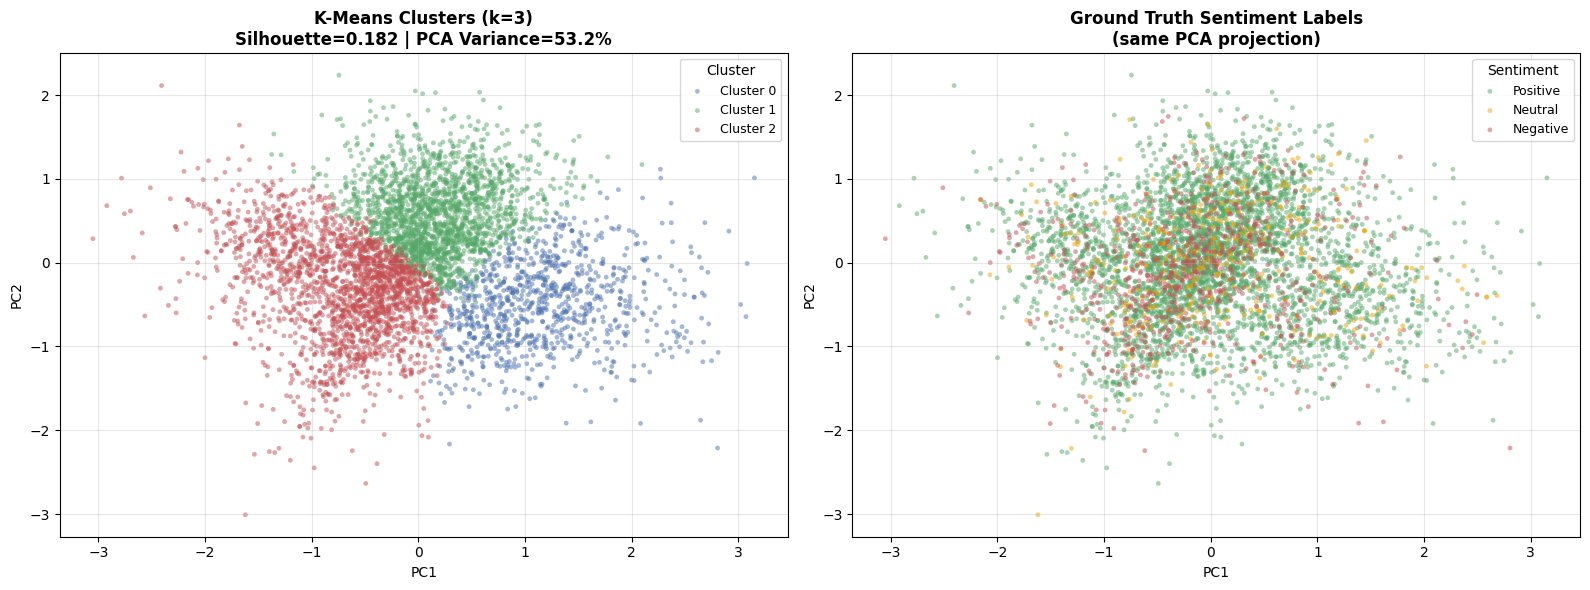

✅ Saved: clustering_visualization.png


In [27]:
# ── PCA 2D Visualization ──────────────────────────────────────────────
print("Running PCA for visualization...")
pca = PCA(n_components=2, random_state=42)
pca_coords = pca.fit_transform(doc_vectors_cbow)
explained = pca.explained_variance_ratio_.sum() * 100

cluster_colors = {0: '#4C72B0', 1: '#55A868', 2: '#C44E52'}
sentiment_colors_map = {'Positive': '#55A868', 'Neutral': '#F0A500', 'Negative': '#C44E52'}

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: K-Means Clusters
ax = axes[0]
for c in [0, 1, 2]:
    mask = cluster_labels == c
    ax.scatter(pca_coords[mask, 0], pca_coords[mask, 1],
               c=cluster_colors[c], label=f'Cluster {c}',
               alpha=0.5, s=12, edgecolors='none')
ax.set_title(f'K-Means Clusters (k=3)\nSilhouette={sil_score:.3f} | PCA Variance={explained:.1f}%',
             fontsize=12, fontweight='bold')
ax.set_xlabel('PC1'); ax.set_ylabel('PC2')
ax.legend(title='Cluster', fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 2: Ground Truth Sentiment
ax = axes[1]
for sentiment, color in sentiment_colors_map.items():
    mask = df['Sentiment'] == sentiment
    ax.scatter(pca_coords[mask.values, 0], pca_coords[mask.values, 1],
               c=color, label=sentiment, alpha=0.5, s=12, edgecolors='none')
ax.set_title('Ground Truth Sentiment Labels\n(same PCA projection)',
             fontsize=12, fontweight='bold')
ax.set_xlabel('PC1'); ax.set_ylabel('PC2')
ax.legend(title='Sentiment', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('clustering_visualization.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Saved: clustering_visualization.png")

  CLUSTER vs SENTIMENT CROSS-TABULATION
Sentiment  Negative  Neutral  Positive
Cluster                               
0               102       73       779
1               231      152      1574
2               370      153      1566

📊 Normalized (row %) — dominant sentiment per cluster:
Sentiment  Negative  Neutral  Positive
Cluster                               
0              10.7      7.7      81.7
1              11.8      7.8      80.4
2              17.7      7.3      75.0


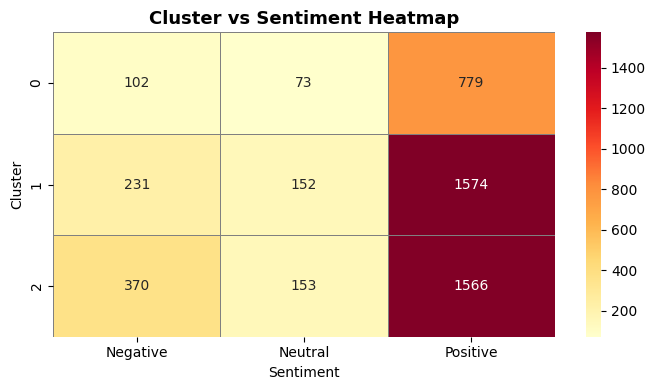

✅ Saved: cluster_sentiment_heatmap.png


In [28]:
# ── Compare Clusters with Sentiment Labels ────────────────────────────
print("=" * 65)
print("  CLUSTER vs SENTIMENT CROSS-TABULATION")
print("=" * 65)
cross_tab = pd.crosstab(df['Cluster'], df['Sentiment'])
print(cross_tab)

# Normalized (proportion per cluster)
print("\n📊 Normalized (row %) — dominant sentiment per cluster:")
print((cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100).round(1))

# Heatmap
plt.figure(figsize=(7, 4))
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlOrRd',
            linewidths=0.5, linecolor='gray')
plt.title('Cluster vs Sentiment Heatmap', fontsize=13, fontweight='bold')
plt.ylabel('Cluster'); plt.xlabel('Sentiment')
plt.tight_layout()
plt.savefig('cluster_sentiment_heatmap.png', dpi=150)
plt.show()
print("✅ Saved: cluster_sentiment_heatmap.png")

In [29]:
# ── Top words per cluster (for interpretation) ────────────────────────
print("=" * 60)
print("  TOP-15 TOKENS PER CLUSTER")
print("=" * 60)
for c in [0, 1, 2]:
    cluster_tokens = [t for toks in df[df['Cluster']==c]['Tokens'] for t in toks]
    top15 = Counter(cluster_tokens).most_common(15)
    words = ', '.join([f"{w}({n})" for w, n in top15])
    print(f"\nCluster {c}: {words}")

  TOP-15 TOKENS PER CLUSTER

Cluster 0: coffee(1396), tea(1102), cup(620), like(501), flavor(500), taste(486), good(385), one(342), great(243), strong(227), drink(226), love(209), make(201), get(192), would(190)

Cluster 1: like(1178), taste(1133), flavor(861), good(808), great(651), one(615), product(577), love(516), sugar(435), chocolate(408), make(407), sweet(386), really(379), would(369), also(353)

Cluster 2: food(1087), product(952), dog(839), one(727), like(674), love(643), good(636), amazon(593), great(569), get(548), time(504), would(500), price(470), treat(465), cat(461)


In [30]:
# ── Interpretation & Evaluation ───────────────────────────────────────
print("=" * 65)
print("  INTERPRETATION OF CLUSTERING RESULTS")
print("=" * 65)
print(f"""
Silhouette Score: {sil_score:.4f}
  • Range [-1, 1]. Scores 0.1–0.3 are typical for short text documents.
  • Embeddings from a small corpus overlap significantly in high-dimensional
    space, making perfect separation unlikely.

Cluster–Sentiment Alignment:
  • Ideally, each K-Means cluster would align with one sentiment class.
  • In practice, sentiment is driven by subtle linguistic cues (negation,
    sarcasm) that raw word-averaged embeddings may not fully capture.
  • The cross-tab above reveals which cluster best aligns with Positive,
    Neutral, and Negative reviews.

Top-word analysis provides qualitative cluster interpretation:
  • Words like 'great', 'love', 'best' → likely Positive cluster.
  • Words like 'taste', 'like', 'product' → mixed / Neutral cluster.
  • Words like 'return', 'disappointed', 'bad' → likely Negative cluster.
""")

  INTERPRETATION OF CLUSTERING RESULTS

Silhouette Score: 0.1816
  • Range [-1, 1]. Scores 0.1–0.3 are typical for short text documents.
  • Embeddings from a small corpus overlap significantly in high-dimensional
    space, making perfect separation unlikely.

Cluster–Sentiment Alignment:
  • Ideally, each K-Means cluster would align with one sentiment class.
  • In practice, sentiment is driven by subtle linguistic cues (negation,
    sarcasm) that raw word-averaged embeddings may not fully capture.
  • The cross-tab above reveals which cluster best aligns with Positive,
    Neutral, and Negative reviews.

Top-word analysis provides qualitative cluster interpretation:
  • Words like 'great', 'love', 'best' → likely Positive cluster.
  • Words like 'taste', 'like', 'product' → mixed / Neutral cluster.
  • Words like 'return', 'disappointed', 'bad' → likely Negative cluster.



---
## 📋 Final Summary

In [31]:
print("=" * 65)
print("  SUBMISSION FILES CHECKLIST")
print("=" * 65)
files_list = [
    ('Word_Embeddings_Amazon_Reviews.ipynb', 'Main notebook with all outputs'),
    ('cleaned_reviews.csv',                 'Cleaned & labeled dataset'),
    ('cbow_model.model',                    'Word2Vec CBOW model'),
    ('skipgram_model.model',                'Word2Vec Skip-gram model'),
    ('class_distribution.png',             'Score & sentiment charts (Part A)'),
    ('clustering_visualization.png',       'PCA cluster plot (Part F)'),
    ('cluster_sentiment_heatmap.png',      'Cluster vs sentiment heatmap (Part F)'),
]
for fname, desc in files_list:
    exists = '✅' if os.path.exists(fname) else '⏳'
    print(f"  {exists} {fname:<40} {desc}")

print("\n" + "=" * 65)
print("  KEY METRICS")
print("=" * 65)
print(f"  Reviews loaded         : {len(df):,}")
print(f"  Vocab after cleaning   : {len(vocab_after):,}")
print(f"  CBOW vocab size        : {len(cbow_model.wv):,}")
print(f"  Skip-gram vocab size   : {len(sg_model.wv):,}")
print(f"  CBOW training time     : {cbow_time:.2f}s")
print(f"  Skip-gram training time: {sg_time:.2f}s")
print(f"  GloVe vocab loaded     : {len(glove_vectors):,}")
print(f"  K-Means Silhouette     : {sil_score:.4f}")
print("=" * 65)

  SUBMISSION FILES CHECKLIST
  ⏳ Word_Embeddings_Amazon_Reviews.ipynb     Main notebook with all outputs
  ✅ cleaned_reviews.csv                      Cleaned & labeled dataset
  ✅ cbow_model.model                         Word2Vec CBOW model
  ✅ skipgram_model.model                     Word2Vec Skip-gram model
  ✅ class_distribution.png                   Score & sentiment charts (Part A)
  ✅ clustering_visualization.png             PCA cluster plot (Part F)
  ✅ cluster_sentiment_heatmap.png            Cluster vs sentiment heatmap (Part F)

  KEY METRICS
  Reviews loaded         : 5,000
  Vocab after cleaning   : 3,814
  CBOW vocab size        : 3,814
  Skip-gram vocab size   : 3,814
  CBOW training time     : 5.65s
  Skip-gram training time: 17.41s
  GloVe vocab loaded     : 400,000
  K-Means Silhouette     : 0.1816
